# Are Points per team distributed according to a power law?

In [62]:
from nba_api.stats.endpoints import playergamelogs
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [138]:
pgl = playergamelogs.PlayerGameLogs(
            #team_id_nullable = 1610612754, # if you want to restrict to a single team
            #player_id_nullable = 201939,   # if you want to restrict to a single player
            season_nullable='2022-23')

# The API will return a dataframe in a single element of a list 
temp_list = pgl.get_data_frames()
df = temp_list[0]

In [139]:
# CREATE AGGREGATE AT GAME-TEAM-PLAYER LEVEL
game_team_player_points = df.groupby(['GAME_ID','TEAM_ID','PLAYER_ID']).agg({"PTS": "sum"})
game_team_player_points = game_team_player_points.rename(columns={'PTS': 'player_pts'})

# CREATE AGGREGATE AT GAME-TEAM LEVEL
game_team_points = df.groupby(['GAME_ID','TEAM_ID']).agg({"PTS": "sum"})
game_team_points = game_team_points.rename(columns={'PTS': 'team_pts'})

# MERGE DATA SETS, REPEATING HIGHER LEVEL DATA OVER THE LOWER LEVEL 
merged_df = pd.merge(game_team_player_points , game_team_points, left_index=True, right_index=True)

# ADD DERIVED COLUMNS
# add rank column (players ranked by pts for each game)
# note: ties in rank are resolved by using whichever record came first.
# E.g. if the two top players on the same team in the same game got 34 points they will be assigned rank 1 and 2.
merged_df['player_pts_rank'] = merged_df.groupby(['GAME_ID','TEAM_ID'])['player_pts'].rank(ascending=False, method='first')

# Add percent of total game points 
merged_df['player_pts_pct'] = merged_df['player_pts'] / merged_df['team_pts']

# sort by pts rank !!! Important to do this before adding cumulative points !!!!
merged_df = merged_df.sort_values(['GAME_ID', 'TEAM_ID', 'player_pts_rank'])

# Add cumulative total points
def cumulative_sum(series):
    return series.cumsum()
merged_df['player_pts_cum'] = merged_df.groupby(['GAME_ID', 'TEAM_ID'])['player_pts'].transform(cumulative_sum)

# Add cumulative pct points
merged_df['player_pts_pct_cum'] = merged_df['player_pts_cum'] / merged_df['team_pts']

# Add pct of players (hard coded to 15 players on a team. So each player is 1/15th)
merged_df['pct_of_players'] = 1/15

# add cumulative pct of players
merged_df['cum_pct_of_players'] = merged_df.groupby(['GAME_ID', 'TEAM_ID'])['pct_of_players'].transform(cumulative_sum)


<AxesSubplot:xlabel='player_pts_rank', ylabel='player_pts_pct'>

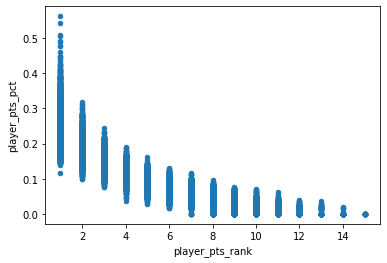

In [140]:
merged_df.plot.scatter(x='player_pts_rank', y='player_pts_pct')

Text(0, 0.5, 'Avg percent of total points')

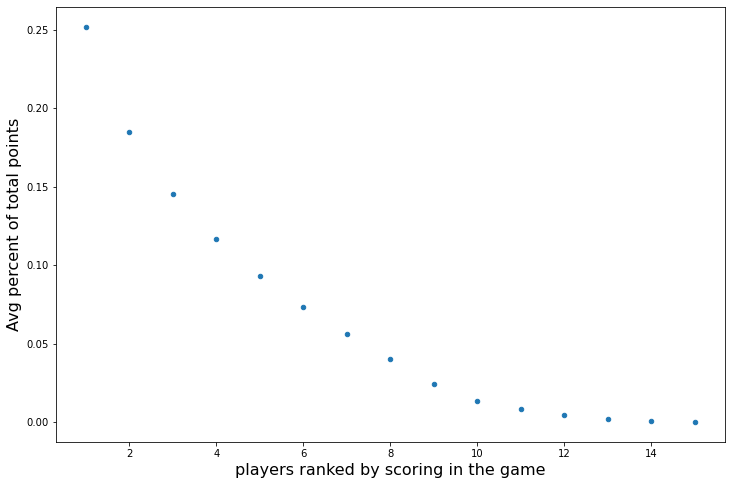

In [141]:
# groupby and take the average to reduce the variance. 

fig, ax = plt.subplots(figsize=(12, 8))

agg = merged_df.groupby('player_pts_rank', as_index=False).agg({'player_pts_pct': 'mean'})
agg.plot.scatter(x="player_pts_rank", y='player_pts_pct', ax=ax)
plt.xlabel('players ranked by scoring in the game', fontsize=16)
plt.ylabel('Avg percent of total points', fontsize=16)


# CUMULATIVE

<AxesSubplot:xlabel='player_pts_rank', ylabel='player_pts_pct_cum'>

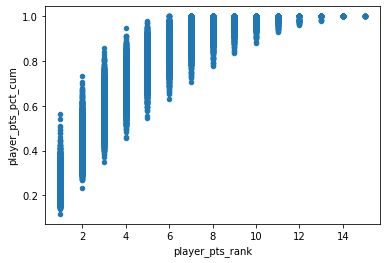

In [143]:
# Cumulative version.
merged_df.plot.scatter(x='player_pts_rank', y='player_pts_pct_cum')

range(1, 12)

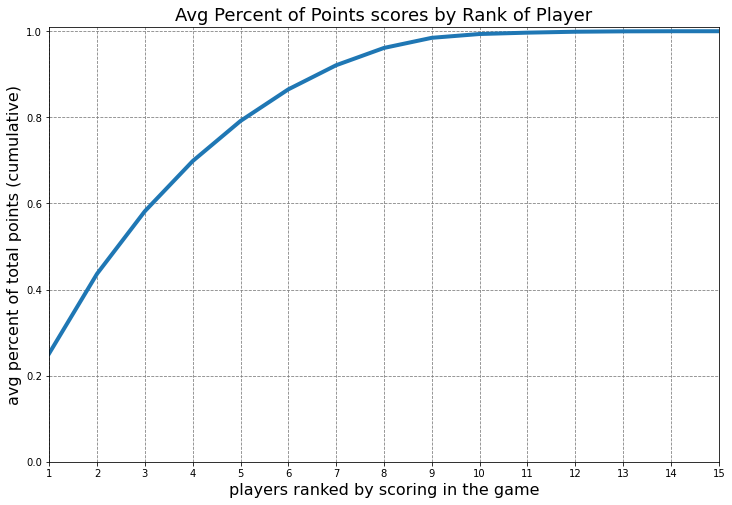

In [151]:
# Cumulative version: groupby and take the average to reduce the variance. 
agg2 = merged_df.groupby('player_pts_rank', as_index=False).agg({'player_pts_pct_cum': 'mean'})

fig, ax = plt.subplots(figsize=(12, 8))

agg2.plot.line(x="player_pts_rank", y="player_pts_pct_cum", grid=True, ax=ax, legend=False, linewidth=4)
 
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.xlabel('players ranked by scoring in the game', fontsize=16)
plt.ylabel('avg percent of total points (cumulative)', fontsize=16)
plt.title('Avg Percent of Points scores by Rank of Player', fontsize=18)
ax.set_xlim(1, 15)
ax.set_ylim(0, 1.01)
ax.set_xticks(range(1,16)) 

# Test to see if it is a power law 

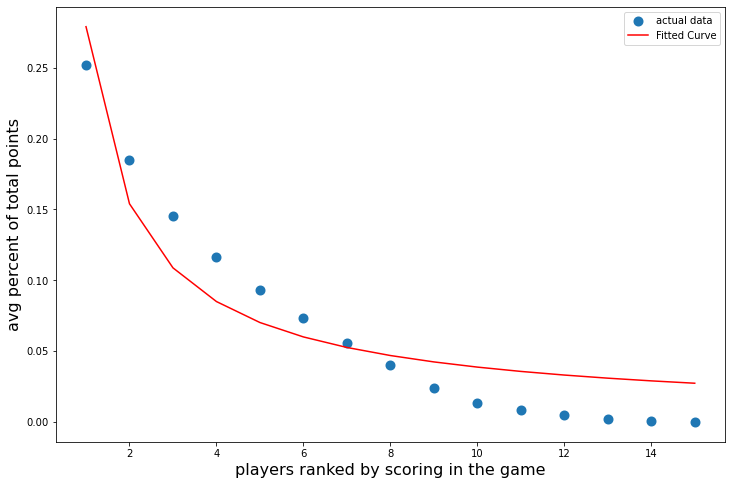

In [152]:
# Fit a power law curve to the data
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def power_law(x, a, b):
    return a * np.power(x, b)

fig, ax = plt.subplots(figsize=(12, 8))


popt, _ = curve_fit(power_law, agg['player_pts_rank'], agg['player_pts_pct'])
a, b = popt

# Plot pdf (not cumulative)
plt.scatter(agg['player_pts_rank'], agg['player_pts_pct'], label='actual data',  linewidth=4)
plt.plot(agg['player_pts_rank'], power_law(agg['player_pts_rank'], a, b), label='Fitted Curve', color='red')
plt.xlabel('players ranked by scoring in the game', fontsize=16)
plt.ylabel('avg percent of total points', fontsize=16)
plt.legend()
plt.show()

# Try making a log-log plot

In [153]:
agg['log_player_pts_rank'] = np.log10(agg['player_pts_rank'])
agg['log_player_pts_pct'] = np.log10(agg['player_pts_pct'])

/Users/ecolson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [154]:
# add rank back in:
agg['rank'] = range(1, len(agg) + 1)
agg['log_rank'] = np.log10(agg['rank'])
agg

,player_pts_rank,player_pts_pct,log_player_pts_rank,log_player_pts_pct,rank,log_rank
0,1.0,0.251854,0.000000,-0.598851,1,0.000000
1,2.0,0.184730,0.301030,-0.733462,2,0.301030
2,3.0,0.145383,0.477121,-0.837485,3,0.477121
3,4.0,0.116431,0.602060,-0.933931,4,0.602060
4,5.0,0.093209,0.698970,-1.030544,5,0.698970
5,6.0,0.073432,0.778151,-1.134114,6,0.778151
6,7.0,0.056086,0.845098,-1.251143,7,0.845098
7,8.0,0.040234,0.903090,-1.395403,8,0.903090
8,9.0,0.024361,0.954243,-1.613306,9,0.954243
9,10.0,0.013555,1.000000,-1.867888,10,1.000000


Text(0, 0.5, 'log of avg percent of total points')

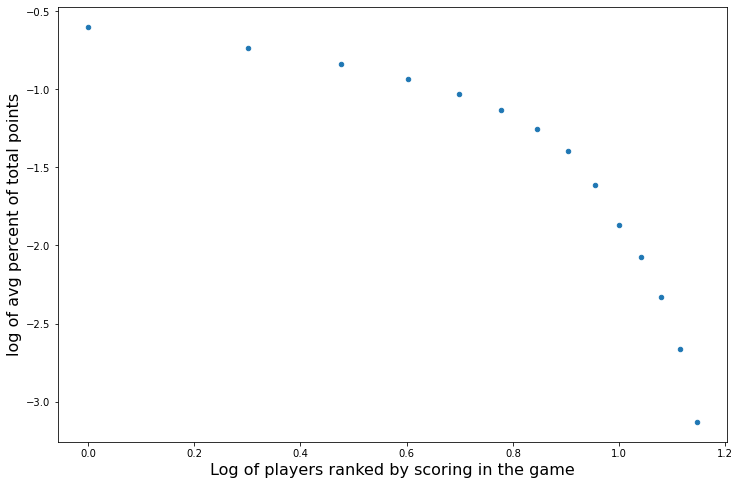

In [155]:
fig, ax = plt.subplots(figsize=(12, 8))

agg.plot.scatter(x='log_rank', y='log_player_pts_pct', ax=ax)

plt.xlabel('Log of players ranked by scoring in the game', fontsize=16)
plt.ylabel('log of avg percent of total points', fontsize=16)





# Here's what a power law looks like

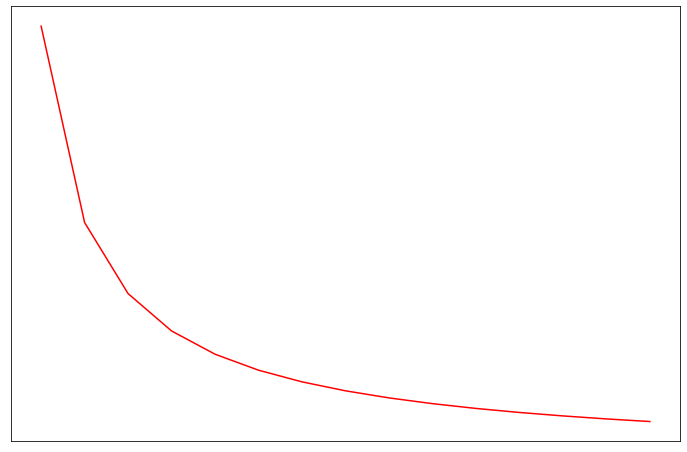

In [156]:
# Fit a power law curve to the data
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def power_law(x, a, b):
    return a * np.power(x, b)

fig, ax = plt.subplots(figsize=(12, 8))


popt, _ = curve_fit(power_law, agg['player_pts_rank'], agg['player_pts_pct'])
a, b = popt

# Plot pdf (not cumulative)
plt.plot(agg['player_pts_rank'], power_law(agg['player_pts_rank'], a, b), label='Fitted Curve', color='red')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()